# Functions to Evaluate Recommendation Models
- Personalization

- Average Raitings with User Recommendation

- Precision at k, Recal at k

- Personal diversity

- General Diversity - Are we recommending unpopular movies

- average of average ratings


Set seeds such that evaluate all of these models on the same set of users 

### Import Recommendation System

1)  Convert recommendation system notebook to .py

2) Import function here using:

from <name.py> import <name of the recomendation function>
    
example: from contentbasedrecommendationsystem import user_content_recommendations
    
3) recommendation_system: give the name of the recommendation system, you want to get the evaluations for   
    
    
### How to run iterations
- Individual model with full data:
    - df1 = sparse dataset
    - cols1 = columns from df1
    - movieIds = moviesIds (row names) from df1
    - keep_movies = movieIds  
    - keep_movies1 = []
    - keep_movies2 = []
    - df2 = False, cols2 = False, recommendation_system_input = False
    - recommendation_system = content_based_recommendations.user_content_recommendations
- Individual model with specific columns:
    - keep_movies = subset of movies (likely either movieIds_tags or movieIds_notags)
        - Evaluate on subset
    - keep_movies1 = same subset 
        - Generate recommendations only from subset
    - Else same
- Combined model with two different input datasets
    - df1 = sparse dataset1 , df2 = sparse dataset2
    - cols1 = columns from df1, col2 = columns from df2
    - keep_movies = movieIds  (evaluate on all movies)
    - keep_movies1 = subset 1
    - keep_movies2 = subset 2
    - keep_movies = movieIds (row names) from df1 or df2 -- identical 
    - recommendation_system_input = content_based_recommendations.user_content_recommendations
    - recommendation_system = content_based_recommendations_combine.content_models_combine

### Content Systems: One Model
- content_initial_eval (processed_df_sparse): genre, actor, director. Cosine similarity between movies
- __Baseline__: contentv2_noMovieNorm_eval (processed_df_sparse): same data, but no normalization of movie vector (true for all others)
- __Description TFIDF__: content_desc_eval (processed_df_desc): top 5 TF-IDF tokens from movie description
    - Add Genre tokens: content_desc_genre_eval (processed_df_desc_genre_sparse): description tokens and genre
- __All meta-data__: content_all_meta_eval (processed_df_all_meta_sparse): genre, actor, director, decade, country, production company 
    - Try also with each individual feature in the "all" version: content_ (genre, actors_directors, decade, country, production) _eval
    - content_baseline_plus_prod_eval: genre, actors, director, production company 
        - country and decade individually perform poorly individually
- __Tags TFIDF__: content_tags_eval (processed_df_tags_sparse): top 5 TF-IDF genome tags
- __Tags Relevant__: content_tags_rel_eval (processed_df_tags_rel_sparse): top 5 genome tags by relevance score
    - __Tags Relevant + Baseline__: content_baseline_tags_rel_eval (processe_df_baseline_tags_rel_sparse): top 5 tags by relevance + baseline features. Attempt to overcome long tail problem
    - __Text TFIDF__: content_text_eval (processed_df_text_sparse): top 5 TF-IDF text field (tags + description). Attempt to overcome long tail problem.

| Model | Personalization | Precision@10 | Recall@10 | Personal diversity | Global diversity | Average rating
| --- | --- | --- | --- | --- | --- | --- 
| Baseline | 0.99 | 0.02 | 0.007 | 0.52 | 6.4 | 3.2
| All meta-data | 0.99 | 0.02 | 0.006 | 0.42 | 1.05 | 3
| Description TFIDF | 0.99 | 0 | 0 | 0.62 | 1.1 | 3.1
| Tags TFIDF | 0.96 | 0.075 | 0.02 | 0.36 | 415 | 3.8
| Tags Relevant | 0.98 | 0.06 | 0.02 | 0.60 | 524 | 3.5
| Text TFIDF | 0.96 | 0.085 | 0.02 | 0.32 | 647 | 3.8
| Tags Relevant + Baseline | 0.99 | 0.045 | 0.02 | 0.64 | 116 | 3.4


- Baseline (genre, actor, director): best set of metadata 
    - Adding in combinations of country, decade, and production company worsen performance -- unimportant features to people's opinions of a movie
    - Actors and directors important to include with genre, else no differentiation between movies that have the same genre list
- Description tokens perform poorly (precision, recall 0)
- Genome tagging performs well in terms of performance (precision, recall) and for personalization, personal diversity,  average rating
    - However, worse for global diversity because 75% of movies do not have tagging, and tags heavily biased towards movies with many ratings.
    - Top 5 relevant genome tags better than top 5 tf-idf tags in personal diversity. Tags TFIDF better (slightly) in precision, recall, average rating
    - Tags capture most important information from other meta-data because include info about most important actors, genres, plot themes
- Combining tags with other metadata to increase coverage (baseline metadata, description tokens) worsens performance
    - Metadata: assuming these movies don't have info related to that tag. Not a valid assumption, just not labeled
    - Description: still not recommending tail even though have description for those. However, for the more popular movies, adding description into the text tfidf does seem to improve performance
    
    
Based on the above, overall conclusion is that genome tagging based on relevance does the best in performance but poor global diversity. Prompted following design: Two separate models for movies with tags and movies without tags. Half recommendations from one, half from the other 
- Performance and credibility from tag model among popular movies
    - Also, people tend to expect recognizable movies in their recommendations so lends to credibilty of system. Preps them to be accepting of the long tail that will increase our overall streaming
- Access to long tail for baseline model among untagged, less popular movies       
--> exploration and exploitation

### Content Systems: Two Models   
(1) Evaluate models on relevant dataset     
(2) Evaluate combined models on full dataset   
    
Still debating between two tag models (TFIDF vs relevant) 
    
- __Relevant Tags Only__: content_tags_rel_only_eval (processed_df_tags_rel_sparse + keep_cols = movieIds_tags): top 5 genome tags by relevance score ONLY with movies that have tags
- __TFIDF Tags Only__: content_tags_only_eval (processed_df_tags_sparse + keep_cols = movieIds_tags): top 5 genome tags by tfidf ONLY with movies that have tags
- __TFIDF Text Only__: content_text_tagsonly_eval (processed_df_text_sparse + keep_cols = movieIds_tags): top 5 tags+description fields by tfidf ONLY with movies that have tags
- __Baseline no tags__: content_baseline_notags_eval (processed_df_sparse + keep_cols = movieIds_notags): basline model (genre, actor, director) only for movies without tags (long tail) 
- __Combined Relevant__: content_twomodels_tags_rel_eval: combination of __Baseline no tags__ and __TFIDF Tags Only__ models using content_based_recommendations_combine system. df1 = baseline no tags, df2 = tags (tfidf) tags
- __Combined TFIDF__: content_twomodels_tags_eval: combination of prior __Baseline no tags__ and __TFIDF Tags Only__ models using content_based_recommendations_combine system. df1 = baseline no tags, df2 = tags (relevant) tags
- __Combined Text__: content_twomodels_text_eval: combination of prior __Baseline no tags__ and __TFIDF Text Only__ models using content_based_recommendations_combine system. df1 = baseline no tags, df2 = text (tfidf) tags

| Model | Personalization | Precision@10 | Recall@10 | Personal diversity | Global diversity | Average rating
| --- | --- | --- | --- | --- | --- | --- 
| Relevant Tags Only | 0.98 | 0.03 | 0.007 | 0.59 | 356 | 3.5
| TFIDF Tags Only | 0.96 | 0.07 | 0.008 | 0.36 | 910 | 3.8
| TFIDF Text Only | 0.95 | 0.075 | 0.02 | 0.31 | 688 | 3.8
| Basline no tags | 0.99 | 0.01 | 0.005 | 0.49 | 1.2 | 3.0
| Combined Relevant | 0.99 | 0.025 | 0.01 | 0.67 | 1.85 | 3.25
| Combined TFIDF | 0.99 | 0.045 | 0.01 | 0.70 | 1.85 | 3.39
| Combined Text | 0.98 | 0.055 | 0.015 | 0.69 | 1.85 | 3.42

- Genome tagging for movies only with tags: Almost identical evaluations to full data, which makes sense as even with full data effectively just ignored movies without tags. 
    - Worse recall = likely artifact of different sample users chosen since different universe. These users happened to have rated more movies positively, thus creating a larger denominator for recall. but precision still performing well. 
    - TFIDF Text is the best on just tags sample 
- Baseline for movies without tags: compared to full data, slightly worse performance in all stats. To be expected since only evaluating on long tail movies. For example, if rarely viewed then low likelihood that they are in the user's test set for precision, recall 
- Combined: performance in between two individual models. Higher personal diversity (evaluated on baseline characteristics because available for all movies)
    - Better than any single models that consider all movies 
    - TFIDF tags clearly better
    
__FINAL MODEL:__ Combined Text

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import operator
import scipy.spatial.distance as distance
from sklearn import metrics 
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import fastparquet
import pickle
import scipy
import sklearn
import content_based_recommendations
import content_based_recommendations_combine

## Load Data

In [2]:
df1 = scipy.sparse.load_npz("processed_df_text_sparse.npz")
#df2 = scipy.sparse.load_npz("processed_df_text_sparse.npz")
df2 = False

ratings = pd.read_pickle('ratings_sample.pkl')
ratings = ratings.reset_index()
movies_raitings = pd.read_parquet('movies_ratings.parq')
movies_raitings = movies_raitings.rename(columns={"avg": "Average_Ratings"})

In [3]:
with open('sparse_metadata_text', "rb") as f:
    cols1 = pickle.load(f)
    movieIds = pickle.load(f)
    
#with open('sparse_metadata_text', "rb") as f:
#    cols2 = pickle.load(f)
#    movieIds = pickle.load(f)
cols2 = False

# movieIds are identical (list of full movies)

In [4]:
# load movieId lists for movies with and without tags so can specify which movies to keep for which models
with open('movieIds_tags', "rb") as f:
    movieIds_tags = pickle.load(f)
with open('movieIds_notags', "rb") as f:
    movieIds_notags = pickle.load(f)

In [5]:
keep_movies = movieIds
keep_movies1 = movieIds_tags
keep_movies2 = []

In [6]:
# use to only get a subset of columns from processed_df_all_meta_sparse
#index = [cols.index(i) for i in cols if i.startswith('production') | i.startswith('genres') | i.startswith('actors') |
#        i.startswith('director')]
#df = df[:, index]
#cols = [cols[i] for i in index]

## Helper Fns

In [7]:
def user_top(movies,n):
    return movies[['title_eng','Average_Ratings']][:n]

def user_movie_id(movies,n):
    return movies['movieId'][:n]

def user_avg_rating(movies,n):
    return movies['Average_Ratings'][:n]

## Specify recommendation system

In [8]:
#recommendation_system_input = content_based_recommendations.user_content_recommendations
#recommendation_system = content_based_recommendations_combine.content_models_combine

recommendation_system_input = False
recommendation_system = content_based_recommendations.user_content_recommendations

## Open file to record evaluations

In [9]:
f = open("evaluations/content_text_tagsonly_eval.txt", "w")

## Evaluation: Personalization



In [10]:
"""
get_users_prediction: returns user prediction

user_matrix: generated user by movies, 0: movie not recommended, 1: movie got recommended

"""
def get_users_prediction(users_list,top_n,users_prediction,recommendation_system, df1, ratings, movieIds, keep_movies1,
                        df2 = False, keep_movies2 = False, recommendation_system_input = False):
    for i in users_list:
        recommendation = recommendation_system(i, df1, ratings, movieIds,
                                               keep_movies1, df2, keep_movies2, recommendation_system_input)
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        users_prediction = users_prediction.append(pd.Series(prediction),ignore_index=True)
        
    return users_prediction

def user_matrix(users_pred):
    data_melt= pd.DataFrame(data=users_pred).reset_index().melt(id_vars='index', value_name='movieId',)
    data_melt = data_melt[['index', 'movieId']].pivot(index='index', columns='movieId', values='movieId')
    cols = data_melt.columns
    for i in cols:
        data_melt[i] = np.where(data_melt[i].isna(), 0, 1)
    return data_melt


def personalization(users_matrix,n):
    # generating cosine similarity between the users
    #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
    #calculating the avg of the element above diagonal 
    #Personalization means 1 - similarity
    #higher the personalization score, better the recommendation system in recommending personalized movies
   
    users_sim = metrics.pairwise.cosine_similarity(users_matrix)
    iu1 = np.triu_indices(n,k=1)
    similarity_avg = np.mean(users_sim[iu1])
    personalization_score = 1 - similarity_avg

    return personalization_score

def cross_fold_eval(unique_users,recommendation_system, df1, keep_movies1, 
                    df2 = False, keep_movies2 = False, recommendation_system_input = False, 
                    k_fold=10,n=10,top_n=10):
    #users_list: List of random n users
    
    kfold_personalization=0
    for i in range(k_fold):
        users_list = random.sample(unique_users, n)
        
        #columns: top_n recommendations
        #users_prediction:  top_n recommendations for n users
        column_names = list(range(top_n))
        users_prediction = pd.DataFrame(columns = column_names)
                
        # getting predictions for sampled users
        users_pred = get_users_prediction(users_list,top_n,users_prediction,recommendation_system, 
                                          df1, ratings, movieIds, keep_movies1,
                                          df2 = df2, keep_movies2 = keep_movies2, 
                                          recommendation_system_input = recommendation_system_input)
        
        # getting user by movies matrix with binary indicators 0: movie not recommended, 1: movie got recommended
        users_matrix = user_matrix(users_pred)
        kfold_personalization+=personalization(users_matrix,n)
    kfold_eval = kfold_personalization/k_fold
    print(f'Personalization score for {k_fold} folds across {n} users for top {top_n} recommendations: {kfold_eval}', file = f)

In [11]:
"""
    unique_users: getting unique user set 
    
    default values given in function
    n: number of users 
    top_n: top number of recommendations (10)
    recommendation_system: Name of the recommendation system
    
"""

unique_users = set(ratings.userId)
start_time = time.time()
cross_fold_eval(unique_users,recommendation_system, df1, keep_movies1, df2 = df2, keep_movies2 = keep_movies2, 
                recommendation_system_input = recommendation_system_input, n = 20)

#end_time = time.time() - start_time
#print(f'Time take {end_time} seconds')

# Precision and Recall 

### Keeping the users who have rated minimum of 20 movies OUT OF target movies (keep_movies)
If model for tagged movies, find users that have rated min 20 tagged movies since this will be the universe for precision,recall
- n_users: Number of users to filter the from the dataset


In [12]:
user_list = ratings[ratings.movieId.isin(keep_movies)].groupby('userId')['userId'].count().reset_index(name="rating_count")
users_list = set(user_list[user_list['rating_count']>=20]['userId'].values)
print(f' Number of users who rated at least 20 movies: {len(users_list)}')

 Number of users who rated at least 20 movies: 115856


In [13]:
random.seed(42)
n_users = 1000
random_users = random.sample(users_list, n_users)
users_ratings = ratings[ratings.userId.isin(random_users)]
len(users_ratings)

95207

### train/test split - Keeping the users distribution similar

In [14]:
# creating train/test empty dataframe

train = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])
test = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])

In [15]:
# spliting each user data equally in train test
for i in random_users:
    #getting individual user index
    random_index =set(users_ratings[users_ratings['userId'] == i].index.values)
    
    # dividing the user ratings count/2
    n_len = np.math.floor(len(random_index)/2)
    

    # getting index for train data
    train_ind = set(random.sample(random_index, n_len))

    # getting index for test data by removing train index from all index for that user
    test_ind = set(random_index-train_ind)
    

    # getting data for that user
    df_train = users_ratings.loc[train_ind]
    df_test = users_ratings.loc[test_ind]
    # appending that user data to train/test df
    
    train = train.append(df_train)
    test = test.append(df_test)

#### random sample a user from train set

In [16]:
n = 20
top_n = 10
random.seed(42)
train_user_id = set(train.userId.values)
random_userId = random.sample(train_user_id, n)
random_userId[0]

122124

In [17]:
def calc_precision_k(recommended_relevant_count,recommended_count):
    precision_k = recommended_relevant_count/recommended_count
    return precision_k

def calc_recall_k(recommended_relevant_count,relevant_count):
    if relevant_count==0:
        return 0
    else:
        recall_k = recommended_relevant_count/relevant_count
        return recall_k
    
def avg_precision_recall(random_userId, keep_movies, df1, keep_movies1, df2 = False, keep_movies2 = False, 
                         recommendation_system_input = False, top_n = 10, k = 5):
    avg_precision=[]
    avg_recall =[]
    tot_rec_rel = []
    for i in random_userId:
        recommendation = recommendation_system(i, df1, train, movieIds, keep_movies1,
                                               df2 = df2, keep_movies2 = keep_movies2, 
                                               recommendation_system = recommendation_system_input)
        # getting the recommended movies @k
        recommended_movies = set(recommendation[:k].movieId)

        # number of recommended movie @k
        recommended_count = k
        # getting relevant movies, where ratings >= 2
        # limit to keep movies as these are the only movies being possibly produced by the recommendation system 
        relevant_movies =set(test[(test.movieId.isin(keep_movies)) &
                                  (test['userId']==i) & (test['rating']>=2) ]['movieId'].values)
        # Total number of relevant movie
        relevant_count = len(relevant_movies)
        # Getting movies that are relevant and recommended
        recommended_relevant_movies = recommended_movies.intersection(relevant_movies)
        # number of relevant recommended movies
        recommended_relevant_count = len(recommended_relevant_movies)
        precision_k = calc_precision_k(recommended_relevant_count,recommended_count)
        recall_k = calc_recall_k(recommended_relevant_count,relevant_count)
        avg_precision.append(precision_k)
        avg_recall.append(recall_k)
        tot_rec_rel.append(recommended_relevant_count)
        
    precision_avg = np.mean(avg_precision)
    recall_avg = np.mean(avg_recall)
    rec_rel_avg = np.mean(tot_rec_rel)

    return precision_avg,recall_avg, rec_rel_avg

## Getting Precision and Recall for n user


### Relevant item: Has in test with rating >= 3
### Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

### Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)   

For combination model with default top 10 (5 recs from each), k = 5 does not make sense because may only be from one movie. Use k = 10 in this case.  

In [18]:
k = 5
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId, keep_movies, df1, keep_movies1, df2, keep_movies2, 
                                                         recommendation_system_input, top_n, k)

print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

In [19]:
k = 10
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId, keep_movies, df1, keep_movies1, df2, keep_movies2, 
                                                         recommendation_system_input, top_n, k)
print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

In [20]:
k = 30
precision_k,recall_k, rec_rel_avg = avg_precision_recall(random_userId, keep_movies, df1, keep_movies1, df2, keep_movies2, 
                                                         recommendation_system_input, top_n, k)
print(f'Avg Precision at {k} for {n} users: {precision_k}', file = f)
print(f'Avg Recall at {k} for {n} users: {recall_k}', file = f)
print(f'Avg Number of relevant recommendations at {k} for {n} users: {rec_rel_avg}', file = f)

# Diversity

## Personal Diversity: 

### Calculate for n users and then do an average.

diversity based off of baseline features in df1 (genre, actors, directors) so that all movies equally comparable


In [21]:
def personal_diversity(top_n,n,list_user, df1, df2, keep_movies1, keep_movies2, recommendation_system_input, cols1):
    random.seed(42)
    rand_user = random.sample(list_user, n)  
    length = len(rand_user)
    # storing diversity for n users
    diversity =[]
    for u in range(length):
        # getting recommended movies
        recommendation = recommendation_system(rand_user[u], df1, ratings, movieIds, keep_movies1,
                                               df2 = df2, keep_movies2 = keep_movies2, 
                                               recommendation_system = recommendation_system_input)
        
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        predicted_index = [movieIds.index(i) for i in prediction] 
        ### diversity based off of baseline features in df1 (genre, actors, directors) so that all movies equally comparable
        user_df = df1[predicted_index, :]
        user_movie_features = pd.DataFrame()
        
        # getting only the columns that have any value 1
        for i in range(len(prediction)):
            nonzero_cols = [cols1[j] for j in user_df[i,:].nonzero()[1]]
            d = {k:1 for k in nonzero_cols}
            d = pd.DataFrame(data = d, index = [prediction[i]])    
            user_movie_features = pd.concat([user_movie_features, d])

        # replace NaN with 0
        user_movie_features = user_movie_features.fillna(0)
        
        # generating cosine similarity between the users
        #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
        #calculating the avg of the element above diagonal 
        sim = metrics.pairwise.cosine_similarity(np.asmatrix(user_movie_features))

        iu1 = np.triu_indices(user_movie_features.shape[0],k=1)
        avg = 1 - np.mean(sim[iu1])
        
        print(f'Diversity of movies recommended for user {rand_user[u]}: {avg}')
        diversity.append(avg)
        
    # calculating avg diversity over n users
    avg_diversity = np.mean(diversity)
    print(avg_diversity)
    print(f'Average diversity over {n} users for their top {top_n} recommendations (0 = identical): {avg_diversity}', file = f)

In [22]:
"""
top_n: top n recommendations
n: number of users

Ignore warning for now - comming from recommendatiom function
Fixed the one from this function
"""

top_n = 10
n = 20
list_user = set(ratings.userId)

personal_diversity(top_n,n,list_user, df1, df2, keep_movies1, keep_movies2, recommendation_system_input, cols1)

# function call for personal diversity

Diversity of movies recommended for user 29185: 0.20444444444444465
Diversity of movies recommended for user 6557: 0.2755555555555559
Diversity of movies recommended for user 72099: 0.7147540449444492
Diversity of movies recommended for user 64198: 0.2000000000000003
Diversity of movies recommended for user 58515: 0.10222222222222255
Diversity of movies recommended for user 36580: 0.18222222222222262
Diversity of movies recommended for user 26869: 0.42666666666666675
Diversity of movies recommended for user 142970: 0.3999999999999999
Diversity of movies recommended for user 22791: 0.6222222222222222
Diversity of movies recommended for user 154800: 0.48444444444444446
Diversity of movies recommended for user 110607: 0.27111111111111097
Diversity of movies recommended for user 8332: 0.2533333333333334
Diversity of movies recommended for user 7812: 0.4878104631722313
Diversity of movies recommended for user 24562: 0.14666666666666706
Diversity of movies recommended for user 57316: 0.44963

## Average Rating 


### Get average rating for n users

1) Getting the top_n ratings of movies recommended to n users.

2) Averaging over the all the ratings

In [23]:
"""
n: number of users
top_n: top n movie recommendations

"""
# random users out of users that have rated at least one of keep_movies
list_user = set(ratings[ratings.movieId.isin(keep_movies)].userId)
n = 20
top_n = 10

In [24]:
random.seed(42)
rand_user = random.sample(list_user, n)  
length = len(rand_user)
avg_rating = []
for u in range(length):
    # getting recommended movies
    recommendation = recommendation_system(rand_user[u], df1, ratings, movieIds, keep_movies1,
                                           df2 = df2, keep_movies2 = keep_movies2, 
                                           recommendation_system = recommendation_system_input)
    recommendation_rating = pd.merge(recommendation, movies_raitings, on = 'movieId')
    prediction = user_avg_rating(recommendation_rating,top_n).values
    avg_rating.append(prediction)

In [25]:
# flatten list 
# can recommend movies without ratings so lists may be diff lengths: won't work in np.mean natively
avg_rating = [item for sublist in avg_rating for item in sublist] 

print(f'Average movie rating of top {top_n} movies recommended to {n} users: {np.round(np.mean(avg_rating),2)}', file = f)

In [26]:
ranges = ['0-1', '1-2', '2-3', '3-4', '4-5']
ad = pd.DataFrame(avg_rating).melt()
ad['ratingrange'] = pd.cut(ad['value'], bins=[0,1,2,3,4,5], labels=ranges, right=True)

Text(0.5, 1.0, 'Ratings - Recommended Movies')

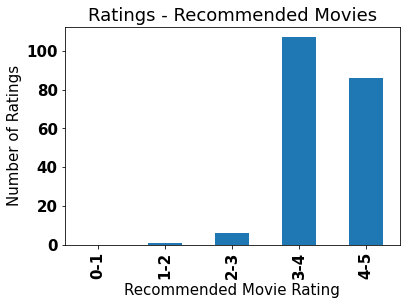

In [27]:
font = {'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

ax = ad.groupby(['ratingrange'])['ratingrange'].count().plot.bar()
ax.set_ylabel('Number of Ratings')
ax.set_xlabel('Recommended Movie Rating')
ax.set_title('Ratings - Recommended Movies')

# Checking for the long tail

- to check are we recommending unpopular movies?

In [28]:
n = 20
top_n = 10
random.seed(42)
rand_user = random.sample(list_user, n)  
length = len(rand_user)
top_n
min_cnt = []

for u in range(length):
    # getting recommended movies
    recommendation = recommendation_system(rand_user[u], df1, ratings, movieIds, keep_movies1,
                                           df2 = df2, keep_movies2 = keep_movies2, 
                                           recommendation_system = recommendation_system_input)
    recommendation_rating = pd.merge(recommendation, movies_raitings, on = 'movieId')
    
    # getting the min rating cnt of the movies recommended
    min_rating_cnt = recommendation_rating[:top_n]['cnt'].min()
    min_cnt.append(min_rating_cnt)

avg_min_cnt = np.mean(min_cnt)

In [29]:
print(f"Average of the minimum count of ratings for {n} user's top {top_n} recommendations (long tail): {np.round(avg_min_cnt,2)}", file = f)

## Close File

In [30]:
f.close()